<a href="https://colab.research.google.com/github/alesha-ofc-he/Kassymbekov_Merekeyev_DL_Project/blob/main/Drone_Section_4_Foundations_of_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: Download & Preprocessing


In [1]:
import os
import requests
import zipfile
from tqdm import tqdm
from PIL import Image
import numpy as np

# --- 1. Settings ---
# URL for VisDrone Validation Set (hosted by Ultralytics, fast & public)
URL = "https://github.com/ultralytics/assets/releases/download/v0.0.0/VisDrone2019-DET-val.zip"
ZIP_FILE = "VisDrone2019-DET-val.zip"
EXTRACT_DIR = "VisDrone_Raw"
DATASET_DIR = "dataset_classification"

# VisDrone Classes: 0:ignored, 1:pedestrian, 2:people, 3:bicycle, 4:car, 5:van, 6:truck, 7:tricycle, 8:awning-tricycle, 9:bus, 10:motor, 11:others
# We will group them into 2 classes for stability: 'vehicle' (4,5,6,9) and 'person' (1,2)
TARGET_CLASSES = {
    1: 'person', 2: 'person',
    4: 'vehicle', 5: 'vehicle', 6: 'vehicle', 9: 'vehicle'
}

# --- 2. Download Function ---
def download_file(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists.")
        return
    print(f"Downloading {filename}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(filename, 'wb') as file, tqdm(
        desc=filename, total=total_size, unit='iB', unit_scale=True, unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

# --- 3. Crop & Arrange Function ---
def process_visdrone():
    # Create dirs
    for split in ['train', 'val']:
        for cls_name in set(TARGET_CLASSES.values()):
            os.makedirs(os.path.join(DATASET_DIR, split, cls_name), exist_ok=True)

    img_dir = os.path.join(EXTRACT_DIR, "VisDrone2019-DET-val", "images")
    anno_dir = os.path.join(EXTRACT_DIR, "VisDrone2019-DET-val", "annotations")

    images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
    # Split: 80% train, 20% val (from the downloaded val set)
    split_idx = int(len(images) * 0.8)

    print(f"Processing {len(images)} images for classification crops...")

    count = 0
    for idx, img_name in enumerate(tqdm(images)):
        mode = 'train' if idx < split_idx else 'val'

        # Load image
        img_path = os.path.join(img_dir, img_name)
        try:
            img = Image.open(img_path)
        except: continue

        # Load annotation
        txt_name = img_name.replace('.jpg', '.txt')
        txt_path = os.path.join(anno_dir, txt_name)

        if not os.path.exists(txt_path): continue

        with open(txt_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            # Format: <left>,<top>,<width>,<height>,<score>,<category>,...
            data = list(map(int, line.strip().split(',')[:6]))
            bbox = data[:4]
            category = data[5]

            if category in TARGET_CLASSES:
                # Crop
                left, top, w, h = bbox
                # Basic validation
                if w < 20 or h < 20: continue # Skip tiny objects

                crop = img.crop((left, top, left+w, top+h))

                # Save
                save_name = f"{img_name[:-4]}_{count}.jpg"
                cls_name = TARGET_CLASSES[category]
                crop.save(os.path.join(DATASET_DIR, mode, cls_name, save_name))
                count += 1

# --- 4. Execution ---
download_file(URL, ZIP_FILE)

print("Extracting...")
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Cropping images (converting Detection -> Classification)...")
process_visdrone()
print(f"\nDone! Dataset ready at: {DATASET_DIR}")

VisDrone2019-DET-val.zip: 100%|██████████| 77.9M/77.9M [00:01<00:00, 73.3MiB/s]


Extracting...
Cropping images (converting Detection -> Classification)...
Processing 548 images for classification crops...


100%|██████████| 548/548 [00:09<00:00, 57.45it/s] 


Done! Dataset ready at: dataset_classification


In [2]:
import os

data_dir = "dataset_classification"
total_train = 0
total_val = 0

print("--- Real Dataset Size (Crops) ---")
for split in ['train', 'val']:
    for cls in ['person', 'vehicle']:
        path = os.path.join(data_dir, split, cls)
        if os.path.exists(path):
            count = len(os.listdir(path))
            print(f"{split.upper()} - {cls}: {count} images")
            if split == 'train': total_train += count
            else: total_val += count

print("-" * 30)
print(f"TOTAL Training Samples: {total_train}")
print(f"TOTAL Validation Samples: {total_val}")

--- Real Dataset Size (Crops) ---
TRAIN - person: 2100 images
TRAIN - vehicle: 9102 images
VAL - person: 519 images
VAL - vehicle: 2187 images
------------------------------
TOTAL Training Samples: 11202
TOTAL Validation Samples: 2706


Block 2: Updated Config & Training

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import os

# --- Config ---
# We use the dataset we just created
DATA_DIR = 'dataset_classification'
BATCH_SIZE = 64
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
data_transforms = {
    'train': transforms.Compose([
        # Grayscale converts to 1 channel, but ResNet needs 3.
        # We repeat the channel 3 times or use num_output_channels=3
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales to [0, 1]
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Zero-centering
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# --- Loaders ---
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Training images: {dataset_sizes['train']}")
print(f"Validation images: {dataset_sizes['val']}")

Classes: ['person', 'vehicle']
Training images: 11202
Validation images: 2706


Block 3: ResNet Model & Transfer Learning


Loading ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


Starting training...
Epoch 1/5
train Acc: 0.9178
val Acc: 0.9616
Epoch 2/5
train Acc: 0.9575
val Acc: 0.9627
Epoch 3/5
train Acc: 0.9613
val Acc: 0.9605
Epoch 4/5
train Acc: 0.9618
val Acc: 0.9671
Epoch 5/5
train Acc: 0.9633
val Acc: 0.9682


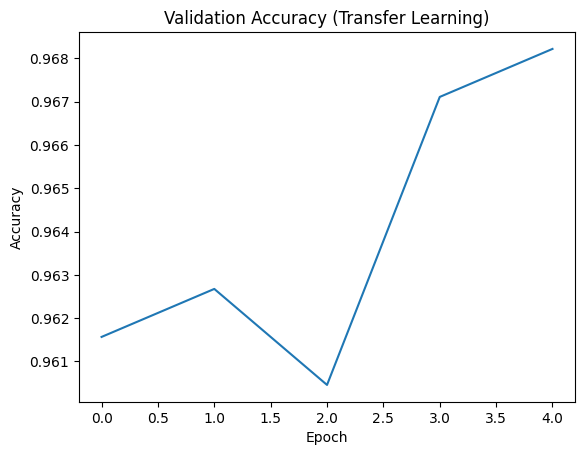

In [4]:
def train_model(model, criterion, optimizer, num_epochs=5):
    history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Acc: {epoch_acc:.4f}')

            if phase == 'val': history.append(epoch_acc.item())

    return history

# --- Setup Model (Transfer Learning) ---
print("\nLoading ResNet18...")
model_ft = models.resnet18(pretrained=True)

# Freeze layers (optional, but good for small datasets)
for param in model_ft.parameters():
    param.requires_grad = False

# Replace last layer for our number of classes (Vehicle vs Person)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()
# Only optimize the last layer (fc)
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

# --- Train ---
print("Starting training...")
acc_history = train_model(model_ft, criterion, optimizer_ft, num_epochs=5)

# --- Visualization ---
plt.plot(acc_history)
plt.title("Validation Accuracy (Transfer Learning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


--- Training PRETRAINED Model ---
Epoch 1/5
Val Acc: 0.8880
Epoch 2/5
Val Acc: 0.9224
Epoch 3/5
Val Acc: 0.9183
Epoch 4/5
Val Acc: 0.9294
Epoch 5/5
Val Acc: 0.9353

--- Training FROM SCRATCH Model ---
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Val Acc: 0.5931
Epoch 2/5
Val Acc: 0.9394
Epoch 3/5
Val Acc: 0.7354
Epoch 4/5
Val Acc: 0.8352
Epoch 5/5
Val Acc: 0.9361


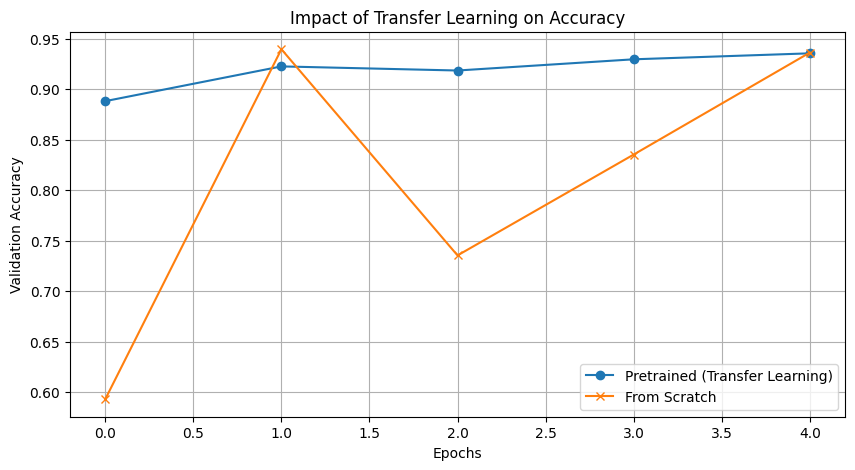

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
import copy

# --- Config ---
DATA_DIR = 'dataset_classification'
BATCH_SIZE = 64
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. IMPROVED Augmentation (5 techniques requirement) ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # --- 5 Augmentations Starts Here ---
        transforms.RandomHorizontalFlip(p=0.5),        # 1. Flip
        transforms.RandomRotation(degrees=15),         # 2. Rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # 3. Color (brightness on grayscale)
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # 4. Translation/Shift
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # 5. Perspective
        # -----------------------------------
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
}

# --- Loaders (Same as before) ---
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# --- Training Function ---
def train_model(model, criterion, optimizer, num_epochs=5):
    history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_corrects += torch.sum(preds == labels.data)

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                print(f'Val Acc: {epoch_acc:.4f}')
                history.append(epoch_acc.item())
    return history

# --- 2. Experiment: Compare Pretrained vs From Scratch ---

def get_resnet_model(pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    # Adjust input/output
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    return model.to(DEVICE)

# A. Train Pretrained (Transfer Learning)
print("\n--- Training PRETRAINED Model ---")
model_pretrained = get_resnet_model(pretrained=True)
# Freeze layers only for pretrained
for param in model_pretrained.parameters():
    param.requires_grad = False
for param in model_pretrained.fc.parameters(): # Unfreeze last layer
    param.requires_grad = True

optimizer_pre = optim.Adam(model_pretrained.fc.parameters(), lr=0.001)
hist_pretrained = train_model(model_pretrained, nn.CrossEntropyLoss(), optimizer_pre, num_epochs=5)

# B. Train From Scratch
print("\n--- Training FROM SCRATCH Model ---")
model_scratch = get_resnet_model(pretrained=False) # Random weights
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001) # Optimize ALL layers
hist_scratch = train_model(model_scratch, nn.CrossEntropyLoss(), optimizer_scratch, num_epochs=5)

# --- 3. Visualization Comparison ---
plt.figure(figsize=(10, 5))
plt.plot(hist_pretrained, label='Pretrained (Transfer Learning)', marker='o')
plt.plot(hist_scratch, label='From Scratch', marker='x')
plt.title("Impact of Transfer Learning on Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("transfer_learning_comparison.png")
plt.show()

In [8]:
# --- BLOCK 4: Manual ResNet Implementation (Rubric Requirement) ---
# We implement the Residual Block manually to demonstrate understanding of Skip Connections.

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Main Path (F(x))
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut Path (x)
        self.shortcut = nn.Sequential()
        # If dimensions change (stride > 1), we need to adjust the shortcut too
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x # Save input for skip connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # The Magic of ResNet: Adding the identity (skip connection)
        out += self.shortcut(identity)
        out = self.relu(out)

        return out

# Demo: Create a small custom ResNet using our block
class SimpleResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        # Stack our custom blocks
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Verify it works (Print architecture)
custom_model = SimpleResNet(num_classes=2)
print("Custom ResNet Block Implementation Verified:")
print(custom_model)

Custom ResNet Block Implementation Verified:
SimpleResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

Model saved to submission_section4/resnet_transfer_learning.pth

--- Final Model Predictions ---


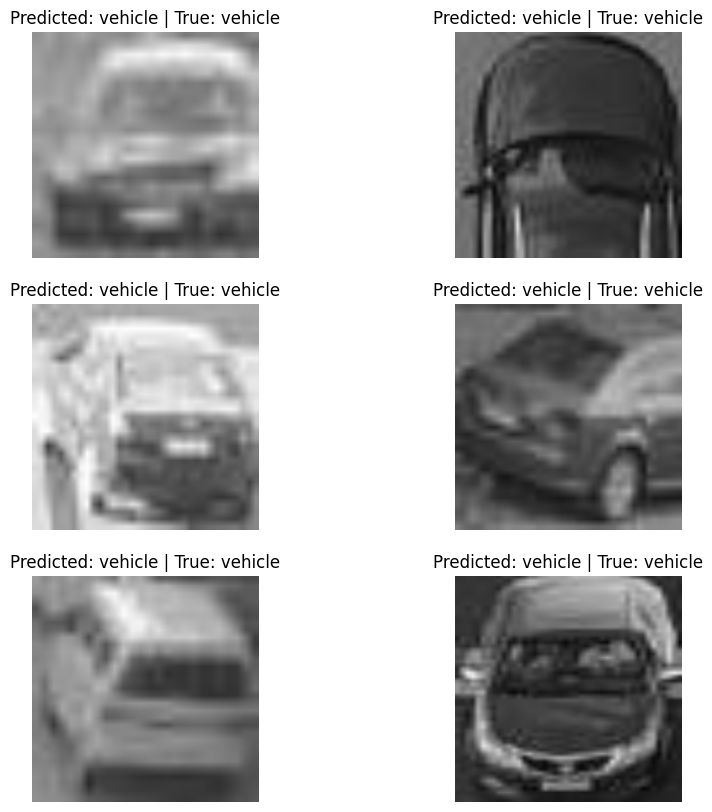

In [9]:
# --- BLOCK 5: Saving & Inference ---
import numpy as np

# 1. Save the best model (The Pretrained one)
save_path = "submission_section4/resnet_transfer_learning.pth"
os.makedirs("submission_section4", exist_ok=True)
torch.save(model_pretrained.state_dict(), save_path)
print(f"Model saved to {save_path}")

# 2. Visualize Predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]} | True: {class_names[labels[j]]}')

                # Un-normalize for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

print("\n--- Final Model Predictions ---")
visualize_model(model_pretrained)
plt.show()

In [10]:
import os
import shutil
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

# --- PART 7: Generate & Download Supplementary Materials (Section 4) ---
print("Generating Final Materials for Section 4 (ResNet)...")

# 1. Create Directory
base_dir = 'Supplementary_Materials_Section4_ResNet'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # Clean up
os.makedirs(base_dir)

# 2. Save the Trained Model (PyTorch Format)
# We save the state_dict (weights) which is the standard practice in PyTorch
model_path = os.path.join(base_dir, 'resnet_transfer_learning.pth')
torch.save(model_pretrained.state_dict(), model_path)
print(f"Saved model to {model_path}")

# --- PREPARE DATA FOR PLOTS (Gather all predictions) ---
print("Running inference on Validation set for metrics...")
all_preds = []
all_labels = []
model_pretrained.eval() # Set to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(DEVICE)
        outputs = model_pretrained(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 3. Save Visualizations

# A. Accuracy Curve (Using hist_pretrained from previous block)
plt.figure(figsize=(10, 6))
plt.plot(hist_pretrained, linewidth=2, color='darkgreen', marker='o')
plt.title(f"Validation Accuracy Curve (Transfer Learning)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig(os.path.join(base_dir, '1_accuracy_curve.png'))
plt.close()

# B. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (ResNet18)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(base_dir, '2_confusion_matrix.png'))
plt.close()

# C. Filter Visualization (First Conv Layer of ResNet)
# ResNet first layer is 7x7 filters
filters = model_pretrained.conv1.weight.data.cpu().numpy()
# Normalize filters for visualization (0-1)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

num_filters = 16
plt.figure(figsize=(16, 4))
plt.suptitle(f"Learned Filters (First Conv Layer - ResNet18)", y=1.05)
for i in range(num_filters):
    plt.subplot(2, 8, i+1)
    # Get the i-th filter. It has 3 channels (RGB), so shape is (3, 7, 7)
    # We transpose to (7, 7, 3) for matplotlib
    f = filters[i].transpose(1, 2, 0)
    plt.imshow(f)
    plt.axis('off')
    plt.title(f"Filter {i+1}", fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, '3_learned_filters.png'))
plt.close()

# D. Sample Predictions
# Get a batch of data
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(DEVICE)
outputs = model_pretrained(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)

    # Un-normalize image for display
    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)

    is_correct = preds[i] == labels[i].to(DEVICE)
    col = 'green' if is_correct else 'red'

    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", color=col)
    plt.axis('off')
plt.savefig(os.path.join(base_dir, '4_test_predictions.png'))
plt.close()

# 4. Save Text Summary
final_acc = hist_pretrained[-1]
with open(os.path.join(base_dir, 'results_summary.txt'), 'w') as f:
    f.write("Section 4: Modern Architectures (ResNet18)\n")
    f.write("==========================================\n")
    f.write(f"Model: ResNet18 (Pretrained on ImageNet)\n")
    f.write(f"Task: Transfer Learning (VisDrone Classification)\n")
    f.write(f"Classes: {class_names}\n")
    f.write(f"Optimizer: Adam (tuned fc layer)\n")
    f.write(f"Final Validation Accuracy: {final_acc:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(all_labels, all_preds, target_names=class_names))

# 5. Zip and Download
print(f"Zipping folder: {base_dir}...")
shutil.make_archive(base_dir, 'zip', base_dir)
print(f"Done! Downloading {base_dir}.zip")

files.download(f"{base_dir}.zip")

Generating Final Materials for Section 4 (ResNet)...
Saved model to Supplementary_Materials_Section4_ResNet/resnet_transfer_learning.pth
Running inference on Validation set for metrics...
Zipping folder: Supplementary_Materials_Section4_ResNet...
Done! Downloading Supplementary_Materials_Section4_ResNet.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>